In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) # this increases width to full screen

In [3]:
import numpy as np # import numerical python
import scipy as sp # import scientific python
import matplotlib.pyplot as plt # import plotting functions
import seaborn as sns # import nicer plotting functions
import pandas as pd # import pandas to import data
import xarray as xr
import os # import os to make filenames etc
from copy import deepcopy # import for copying
import matplotlib as mpl
import matplotlib.font_manager
from matplotlib import cm
from scipy.stats import distributions

In [4]:
def bincalculator(data):
    # bincalculator function
    # reads in data and generates bins according to Freedman-Diaconis rule
    # ================INPUTS============= 
    # data is data to be histogrammed
    # ================OUTPUT============= 
    # bins
    N = len(data)
    mu = np.mean(data)
    sigma = np.std(data)

    binwidth = np.multiply(np.multiply(np.power(N, np.divide(-1,3)), sigma), 3.5)
    bins = np.linspace(np.min(data), np.max(data), int((np.max(data) - np.min(data))/binwidth)+1)
    return bins

In [5]:
DT = 0.1 # our diffusion coefficient
t = np.linspace(0, 1000*DT, 1000) # make time series
sigmaT = np.sqrt(2*(DT*np.diff(t)[0])) # get dimensionless translational diffusion cofficient (good explanation
# in Allen, M. P.; Tildesley, D. J. Computer Simulation of Liquids, 2nd ed.; Oxford University Press, 2017)
displacements = np.random.normal(loc=0, scale=sigmaT, size=(3, len(t)))
coords = np.cumsum(displacements, axis=1)
X = coords[0, :]
Y = coords[1, :]
Z = coords[2, :]

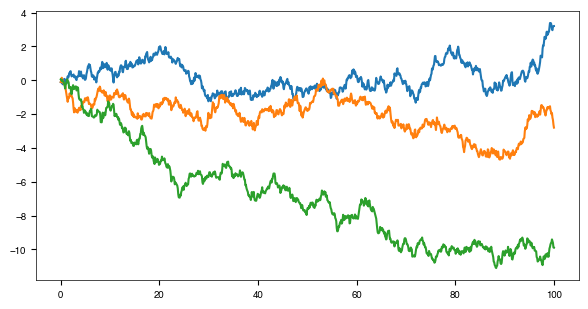

In [6]:
plt.plot(t, X)
plt.plot(t, Y)
plt.plot(t, Z)

In [7]:
def CVE_Eq14(x, t, R=1./6):
    # CVE_Eq14 function
    # takes positions and uses equation 14 from
    # Vestergaard, C. L.; Blainey, P. C.; Flyvbjerg, H
    # Phys. Rev. E 2014, 89 (2), 022726. 
    # https://doi.org/10.1103/PhysRevE.89.022726.
    # to estimate diffusion coefficient and
    # localisation precision
    # ================INPUTS============= 
    # x is 1D positions
    # t is time
    # R is R parameter (see Equation 5 of paper)
    # ================OUTPUT============= 
    # D is diffusion coefficient estimate
    # sigma is localisation precision
    # varD is variance of D
    diffX = np.diff(x)
    mult = np.mean(np.multiply(diffX[:-1], diffX[1:]))
    deltaX_sqr = np.mean(np.square(diffX))
    deltat = np.mean(np.unique(np.diff(t)))
    D = np.add(np.divide(deltaX_sqr, np.multiply(2, deltat)), np.divide(mult, deltat))
    
    sigma = np.sqrt(np.multiply(R, deltaX_sqr) + np.multiply((2*R - 1), mult))
    
    epsilon = np.subtract(np.divide(np.square(sigma), np.multiply(D, deltat)), np.multiply(2, R))
    N = len(x)
    varD = np.multiply(np.square(D), (((6 + 4*epsilon + 2*np.square(epsilon))/N) + ((4*np.square(1+epsilon))/np.square(N))))
    
    return D, sigma, varD

In [8]:
def CVE_Eq16(x, sigma, t, R=1./6):
    # CVE_Eq16 function
    # takes positions and uses equation 16 from
    # Vestergaard, C. L.; Blainey, P. C.; Flyvbjerg, H
    # Phys. Rev. E 2014, 89 (2), 022726. 
    # https://doi.org/10.1103/PhysRevE.89.022726.
    # to estimate diffusion coefficient and
    # localisation precision
    # ================INPUTS============= 
    # x is 1D positions
    # sigma is precision of estimations of x
    # t is time
    # R is R parameter (see Equation 5 of paper)
    # ================OUTPUT============= 
    # D is diffusion coefficient estimate
    # varD is variance of D
    diffX = np.diff(x)
    sigma_squared = np.square(np.mean((sigma)))
    deltaX_sqr = np.mean(np.square(diffX))
    deltat = np.mean(np.unique(np.diff(t)))
    D = np.divide(np.subtract(deltaX_sqr, np.multiply(2., sigma_squared)), np.multiply(np.multiply(2, np.subtract(1., np.multiply(2., R))), deltat))
    print(np.subtract(deltaX_sqr, np.multiply(2., sigma_squared)))
    varsigma = np.var(np.square(sigma))
    epsilon = np.subtract(np.divide(np.square(sigma), np.multiply(D, deltat)), np.multiply(2, R))
    N = len(x)
    varD = np.add(np.divide(np.multiply(np.square(D), (2 + 4*epsilon + 3*np.square(epsilon))), N*np.square(1 - 2*R)), np.divide(varsigma, (np.square(deltat)*np.square(1 - 2*R))))
    
    return D, varD

In [9]:
# CVE should return accurate D (Eq 14 in case of no motion blur)
CVE_Eq14(X, t)

(0.10407569492335826, 0.05924226325357157, 6.518821819799723e-05)

In [10]:
def multiCVEtest(Ds, ntests):

    results = np.zeros([3, len(Ds), ntests])

    for i in np.arange(len(Ds)):
        for j in np.arange(ntests):
            DT = Ds[i]
            t = np.linspace(0, 100*DT, 1000) # make time series
            sigmaT = np.sqrt(2*(DT*np.diff(t)[0])) # get dimensionless translational diffusion cofficient (good explanation
            # in Allen, M. P.; Tildesley, D. J. Computer Simulation of Liquids, 2nd ed.; Oxford University Press, 2017)
            displacements = np.random.normal(loc=0, scale=sigmaT, size=(1, len(t)))
            coords = np.cumsum(displacements, axis=1)
            X = coords[0, :]
            results[:, i, j] = CVE_Eq14(X, t)
    return results

In [11]:
Ds = np.logspace(-1, 1, 10)
ntests = 10000
results = multiCVEtest(Ds, ntests)



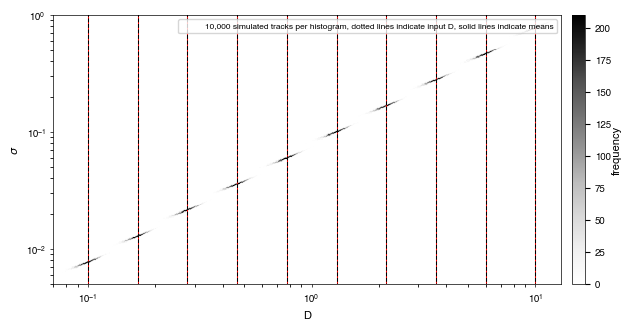

In [13]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


plt.rcParams['figure.figsize'] = [7, 3.5]
plt.rcParams['font.size'] = 7

# panel labels are 8 point font, ticks are 7 point font, annotations and legends are 6 point font

# The maximum published width for a one-column
# figure is 3.33 inches (240 pt). The maximum width for a two-column
# figure is 6.69 inches (17 cm). The maximum depth of figures should be 8 ¼ in. (21.1 cm).

plt.rcParams['svg.fonttype'] = 'none'
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams['axes.linewidth'] = 0.5 # set the value globally
lw=0.75
lwg=0.25
lwax = 0.5

fig, axs = plt.subplots(1, 1)

for i in np.arange(1):
    axs.xaxis.set_tick_params(width=0.5, length=2)
    axs.yaxis.set_tick_params(width=0.5, length=2)

for i in np.arange(len(Ds)):
    x=results[0, i, :]
    y=np.sqrt(results[2, i, :])
    hist1 = axs.hist2d(x=x, y=y, bins=[bincalculator(x), bincalculator(y)], cmap='Greys');
    axs.vlines(x=np.mean(x), ymin=0, ymax=750, color='r', lw=lw)
    axs.vlines(x=Ds[i], ymin=0, ymax=750, ls='--', color='k', lw=lw)

cbar = plt.colorbar(hist1[3], fraction=0.045, pad=0.02, ax=axs, location='right')
cbar.set_label(r'frequency', rotation=90, labelpad=1, fontsize=8)
axs.plot(0, 0, label='10,000 simulated tracks per histogram, dotted lines indicate input D, solid lines indicate means', alpha=0)
plt.xlim(7e-2, 13)
plt.ylim(5e-3, 1)
plt.xscale('log')
plt.yscale('log')
axs.set_ylabel(r'$\sigma$', fontsize=8)
axs.set_xlabel('D', fontsize=8)
axs.legend(fontsize=6)

writefolder = '/home/jbeckwith/Documents/Dropbox (Cambridge University)/Chemistry/Lee/Talks+Posters/Subgroup/20230831/fig'
plt.savefig(os.path.join(writefolder, 'CVE_2D.svg'), format='svg', dpi=1200, transparent=True, bbox_inches='tight')
plt.show(block=False)

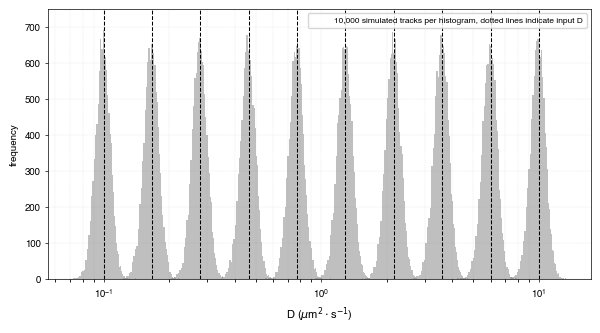

In [14]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


plt.rcParams['figure.figsize'] = [7, 3.5]
plt.rcParams['font.size'] = 7

# panel labels are 8 point font, ticks are 7 point font, annotations and legends are 6 point font

# The maximum published width for a one-column
# figure is 3.33 inches (240 pt). The maximum width for a two-column
# figure is 6.69 inches (17 cm). The maximum depth of figures should be 8 ¼ in. (21.1 cm).

plt.rcParams['svg.fonttype'] = 'none'
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams['axes.linewidth'] = 0.5 # set the value globally
lw=0.75
lwg=0.25
lwax = 0.5

fig, axs = plt.subplots(1, 1)

for i in np.arange(1):
    axs.xaxis.set_tick_params(width=0.5, length=2)
    axs.yaxis.set_tick_params(width=0.5, length=2)


for i in np.arange(len(Ds)):
    axs.hist(results[0, i, :], bins=bincalculator(results[0, i, :]), color='gray', alpha=0.5)
    axs.vlines(x=Ds[i], ymin=0, ymax=750, ls='--', color='k', lw=lw)

axs.plot(0, 0, label='10,000 simulated tracks per histogram, dotted lines indicate input D, solid lines indicate means', alpha=0)
axs.set_ylim([0, 750])    
axs.grid(True,which="both",ls="--",c='gray', lw=lwg, alpha=0.25)  

axs.legend(fontsize=6)
axs.set_xscale('log')
axs.set_xlabel(r'D', fontsize=8)
axs.set_ylabel('frequency')
writefolder = '/home/jbeckwith/Documents/Dropbox (Cambridge University)/Chemistry/Lee/Talks+Posters/Subgroup/20230831/fig'

plt.savefig(os.path.join(writefolder, 'CVE.svg'), format='svg', dpi=1200, transparent=True, bbox_inches='tight')
plt.show(block=False)